In [52]:
import pandas as pd
import numpy as np
import pywt
import os
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.signal import butter
from scipy.signal import filtfilt
from statistics import mean, variance
from scipy.signal import iirnotch

In [53]:
# нет ли там ошибки в коде матлаба? - там на обоих фильтрах стоит high
# для мышки 5 там наны после фильтрации, не знаю почему (https://github.com/scipy/scipy/issues/8166 - 
# но у меня там не аналоговый фильтр, да и на остальных примерах работает)
# ну и на мышках я глазами в половине случаев не вижу тета и p волны

# внезапно тупой вывод - на первой итерации искать theta +p - waves is easier on the raw signal? - НЕТ
# ИДЕЯ - через вивлеты ищем пики, а остальное смотрим на исходном сигнале
# если удалять более 3 уровней вивлет разложения - начинается задержка по времени (пики смещаются)
# мышкам вообще нельзя удалять больше 2 слоёв 

fs = 512
lcf = 0.05
hcf = 100

In [64]:
dog = '/Users/polinaturiseva/Downloads/mammals_dataset/text_format/dog_17/Dog_07/electrography_Dog_07.txt'
rabbit = '/Users/polinaturiseva/Downloads/mammals_dataset/text_format/rabbit_20/Rabbit_01_part_5/electrography_Rabbit_01_part_5.txt'
mouse = '/Users/polinaturiseva/Downloads/mammals_dataset/text_format/mouse_8/Mouse_08/electrography_Mouse_08.txt'

 собаки - 3 пик после R в вивлет разложении (короче берём все пики в вивлетах между RR и 2 максимальных из них - вершины тета и p пиков)
 кролики - берём все пики в вивлетах между RR и ищем 2 максимальных, таких что они различаются примерно в 2 раза(?)
 мышки - после R пика ищем максимум из последующих 3 пиков из вивлетов - это вершина т волны, дальше идём по вивлету - ищем пока функция уйдёт в минимум с двух сторон (там надо дать какой-то финт ушами, тк даже вивлеты немного скачут вверх вниз), после нахождения границы тета волны ищем след пик - это пик p волны и оттуда уже ищем его границы опять
 
 финт ушами - после 

идея
1) посмотреть на данные - увидеть, что они смещённые, поэтому их придётся нормализовать/стандартизовать
1-1) фильтры на 1-45 Гц?
1-2) окно хэмминга + фурье?
2) потом можно возвести в квадрат и find_peaks найти R пик, а умножением на -1 и find_peaks можно найти Q и R падения?
3) попробовать применить  https://dsp.stackexchange.com/questions/45718/real-time-wavelet-decomposition-and-reconstruction-for-ecg-feature-extraction 
wt = modwt(rawECGsignal_buffer,5);
wtrec = zeros(size(wt));
wtrec(4:5,:) = wt(4:5,:);
filtered = imodwt(wtrec,'sym4');
4) ?

In [ ]:
path='/Users/polinaturiseva/Downloads/mammals_dataset/text_format'

In [303]:
def get_pathes(path_train):
    files = []
    for r, d, f in os.walk(path_train):
        for file in f:
            files.append(os.path.join(r, file))
    return files


# folders - названия кореневых папок с животными
# subfolders - названия подпапок для каждого животного 
def get_folders_and_subfolders():
    folders = os.listdir (path)
    subfolder=[]
    for i in folders:
        subfolder.append(os.listdir(path+'/'+i))
    return folders, subfolder


def folder_and_subfolders_for_animal(animal):
    folders = os.listdir (path)
    folder = ""
    for i in folders:
        if animal in i:
            folder = i
    subfolder = (os.listdir(path+'/'+folder))
        
    return folder, subfolder
    

def upload_file (folder, subfolder_name, reverse=False):
    way = path+'/'+folder+'/'+subfolder_name+'/electrography_'+subfolder_name+'.txt'
    if reversed:
        file = np.loadtxt(way, skiprows=14)*(-1)
    else:
        file = np.loadtxt(way, skiprows=14)
    return file

In [ ]:
# ' в matlab = транспонирование
# filtfilt проходит в обе стороны
t = np.linspace(0, 1.0, 2001)
xlow = np.sin(2 * np.pi * 5 * t)
print(xlow.shape)

def butterworth_filtering(lcf, hcf, fs, ecg):
    # removes all frequencies less 0.05 Hz
    [b_bas, a_bas] = butter(2, lcf/(fs/2), 'high')
    # removes all frequencies greater 100 Hz
    [b_lp, a_lp] = butter(5, hcf/(fs/2), 'high')
    bpfecg = ecg - filtfilt(b_lp, a_lp, ecg)
    bpfecg = filtfilt(b_bas, a_bas, bpfecg)
    return bpfecg


# разбивает исходный массив на несколько массивов, выкидывая участки с артефактами
# но при этом сначала надо прогнать батерворд фильтр, тк он даёт краевые эффект

# надо ли чистить рябь? (см картинки рябь в загрузках на локалке) - да, надо подумать как
# currently not working
def get_rid_of_artifacts(arr, lim):
    final_arr = []
    to_drop ,_ = find_peaks(arr, height=lim)
    start_point = []
    end_points = []
    for i in range(0, len(to_drop)):
        if start_point == to_drop[i]:
            continue
        final_arr.append(arr[start_point:to_drop[i]-1])
        start_point=to_drop[i]+1
    return final_arr

In [ ]:
#interval- from start to start
#segment from end to start
#pqrst
def create_metrics():
    names=["QRS interval", 
           "S-S", 
           "Theta-Theta", 
           "R-R", 
           'Q-Q', 
           'P-P', 
           'P-R interval', 
           'P-R segment',
           'S-T interval',
           'S-T segment',
           'Q-T interval',
           'Q-T segment',
           'P interval',
           'T interval']
    metrics=pd.DataFrame(columns=names)
    return metrics

In [435]:
# https://dsp.stackexchange.com/questions/47437/discrete-wavelet-transform-visualizing-relation-between-decomposed-detail-coef
# функция для вивлетов брались из примера по ссылке выше
# попробовать вейвлет Daubechies 8

#find p should be false for mice
def find_q_s_t_p(r, arr, lev, animal, find_p=True):
    q = []
    s = []
    theta_peak = []
    theta_start = []
    theta_end = []
    p_peak = []
    p_start = []
    p_end = []
    all_peaks = find_peaks(arr)
    is_first = True
    ecg_after_wavelet = wavelets(arr)
    s_pos = 0
    for i in r:
        pos = i
        while arr[pos]>=arr[pos-1]:
            pos = pos-1
        q.append(pos)
        pos = i
#         if pos+1!=len(arr)
        while pos+1!=len(arr) and arr[pos]>=arr[pos+1]:
            pos = pos+1
        if pos+1==len(arr):
            break
        s.append(pos)
        
        if not is_first and animal!='mouse':
#             ecg_after_wavelet = wavelets(arr[prev:cur])
            # indexes from [0; cur-prev]
            cur=q[s_pos]
#             wave_mins, _ = find_peaks(ecg_after_wavelet*(-1))
            sub_ar_for_theta_peak = list(arr[prev:int(round((cur-prev)*0.6)+prev)])
            sub_ar_for_p_peak = list(arr[int(round((cur-prev)*0.6)+prev):cur])
            theta_peak.append(sub_ar_for_theta_peak.
                                       index(max(sub_ar_for_theta_peak))+prev)
            p_peak.append(int(sub_ar_for_p_peak.
                                       index(max(sub_ar_for_p_peak))+prev+round((cur-prev)*0.6)))
             
        prev = s[s_pos]
        s_pos+=1  
        is_first = False
    return np.array(q), np.array(s), np.array(theta_peak), np.array(p_peak)
    
    
def wavelets(ecg, lev_to_decompose=6, lev_to_recontr=3):
    decontr = pywt.wavedec(ecg, 'sym4', 'ppd', lev_to_decompose)
#     reconstr = pywt.waverec(rabbit_ex_wav[:-lev_to_recontr] + [None] * lev_to_recontr, 'sym4')
    reconstr = pywt.waverec(decontr[:-lev_to_recontr] + [None] * lev_to_recontr, 'sym4')
    return reconstr


# умножение на маску 1, -1, чтобы ложно не определялись нижние пики
def find_r(ecg, animal):
    ecg_ar = np.array(ecg)
    ecg=list(ecg)
    sign = np.where(ecg_ar>0, 1, -1)
    ecg_sq = [item*item for item in ecg]
    ecg_sq= ecg_sq*sign
    
#     peaks, _ = find_peaks(ecg_sq, distance=80)
    if animal == 'mouse':
        peaks, _ = find_peaks(ecg_sq, distance=80)
    else:
        peaks, _ = find_peaks(ecg_sq, distance=100, height=0.02)
        
    amp=[ecg[int(i)] for i in peaks]
    if len(amp)==0:
        return None, None, None, None
    av = mean(amp)
    if len(amp)>1:
        var = variance(amp)
    else:
        var = amp[0]
    if av<0:
        ecg = [i * (-1) for i in ecg]
        return find_r(ecg, animal)
    else :
        return peaks, av, var, np.array(ecg) 
    
#     return find_peaks(ecg, distance=100)
  
    
#выкидывает ещё 2 секунды до и после артефакта
def filt_electrodes(ecg, av, var):
    indexes_to_drop = np.where(abs(ecg)>abs(av)+abs(var))[0] 
    start_drop = []
    end_drop = []
    pos = 0
    while pos < (len(indexes_to_drop)-1):
        if indexes_to_drop[pos] - 2*fs<0:
            start_drop.append(0)
        else:
            start_drop.append(indexes_to_drop[pos] - 2*fs)
        
        while (len(indexes_to_drop)-1)>pos and indexes_to_drop[pos+1] - indexes_to_drop[pos] <100:
            pos+=1
        if indexes_to_drop[pos]+2*fs >= len(ecg):    
            end_drop.append(len(ecg))
            break
        else:
            end_drop.append(indexes_to_drop[pos]+2*fs)
        pos+=1
        
    ecg_filtered = []
    for i in range(len(end_drop)-1):
        if i==0:
            if start_drop[0]<100:
                continue
            else:
                ecg_filtered.append(ecg[0:start_drop[0]])
        else:
            ecg_filtered.append(ecg[end_drop[i-1]:start_drop[i]])
            
    if len(end_drop)>0:
        if end_drop[-1]==len(ecg) or len(ecg)-end_drop[-1]<100:
            pass
        else:
            ecg_filtered.append(ecg[end_drop[-1]:len(ecg)])
        
    return ecg_filtered, len(end_drop), start_drop, end_drop
    
# todo butterworth filter on 3 mice returns nones - check why, maybe data is damaged        
def step_by_step(folder, subfolder_name, animal, lim = 1, level = 6, qrs_approx=30):
    file = upload_file (folder=folder, subfolder_name=subfolder_name)
    file = butterworth_filtering (lcf=lcf, hcf=hcf, fs=fs, ecg=file)
#     arr = get_rid_of_artifacts(file, lim)
    arr =file
    preprocessed_arr = []
    r_peaks = []
    q_peaks =[]
    s_peaks =[]
    theta_peaks =[]
    p_peaks =[]
    array = []
    r_p, r_av, r_var, arr = find_r(arr, animal=animal)
    arr, drops, start_drops, end_drops = filt_electrodes(arr, r_av, r_var)
    for i in range(len(arr)):
        if len(arr[i])==0:
            continue
#         preprocessed_arr = preprocessed_arr.append(pywt.wavedec(arr, 'sym4', 'ppd', level))
#         print(preprocessed_arr)
        r_, av_h, std, _ = find_r(arr[i], animal=animal)
        if r_ is None:
            continue
        r_peaks.append(r_)
        q_, s_, theta_, p_ = find_q_s_t_p(r_, arr[i], animal=animal, lev = level)
        q_peaks.append(q_)
        s_peaks.append(s_)
        theta_peaks.append(theta_)
        p_peaks.append(p_)
        array.append(arr[i])
    return q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks, drops, start_drops, end_drops, array


def shifted_points(points, loc, start, shift):
    points_ = np.array(points)
    loc_points = np.array(np.where((points_<start+shift) & (points_>start)))
    x = (points_[loc_points] - start).reshape(-1) 
    y = loc[points_[loc_points] - start].reshape(-1)
    return x, y


def find_amplitudes(peaks, ecg):
    amp = [ecg[i] for i in peaks]
    return amp


# period of wave
def find_period(peaks):
    dist = []
    for i, j in zip(peaks[:len(peaks)-1], peaks[1:]):
        dist.append(j-i)
    return dist


# for finding distances between peaks, intervals or segments
# peaks_one should be logically before peaks_two
def find_distance(peaks_one, peaks_two):
    dist = []
    if peaks_one[0]>=peaks_two[0]:
        m = min(len(peaks_one),len(peaks_two)-1)
        for i in range(m):
            dist.append(peaks_two[i+1]- peaks_one[i])
    else:
        m = min(len(peaks_one),len(peaks_two)-1)
        for i in range(m):
            dist.append(peaks_two[i+1]- peaks_one[i])
                
    return dist 
        
    
# will be saved in local directory 
def draw_graph(filtered_ecg, q_ar=[], s_ar=[], r_ar=[], p_ar=[], t_ar=[], 
               p=True, theta=True, q=True, r=True, s=True,
               save=False, name=None, start=0, shift=2500):

    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(np.zeros(shift,))
    
    plt.plot(filtered_ecg[start:start+shift], 'blue')
    loc = filtered_ecg[start:start+shift]
    
    if (len(q_ar)>0) and q:
        x, y = shifted_points(q_ar, loc, start, shift)
        plt.plot(x, y, 'o',  label='q')
    
    if (len(r_ar)>0) and r:
        x, y = shifted_points(r_ar, loc, start, shift)
        plt.plot(x, y, 'o',  label='r')
    
    if (len(s_ar)>0) and s:
        x, y = shifted_points(s_ar, loc, start, shift)
        plt.plot(x, y, 'o',  label='s')
    
    if (len(p_ar)>0) and p:
        x, y = shifted_points(p_ar, loc, start, shift)
        plt.plot(x, y, 'o',  label='p')
    
    if len(t_ar)>0 and theta:
        x, y = shifted_points(t_ar, loc, start, shift)
        plt.plot(x, y, 'o',  label='t')
        
    plt.legend()
    if name is not None:
        plt.title(name)
        
    if save:
        plt.savefig(name)
    

In [433]:
def flatten_list(l):
    lst = [item for sublist in l for item in sublist]
    return lst
    

def filter_empty(l):
    lst = []
    for i in l :
        if len(i)>0:
            lst.append(i)
    return lst
    
    
# for one animal
def animal_describe(q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks, arr, 
                p=True, theta=True, q=True, r=True, s=True):
    q_amp = []
    r_amp = []
    s_amp = []
    t_amp = []
    p_amp = []
    
    p_peaks_interval = []
    q_peaks_interval = []
    r_peaks_interval = []
    s_peaks_interval = []
    t_peaks_interval = []
    
    qrs_interval = []
    qr_interval  = []
    rs_interval  = []
    st_interval  = []
    pq_interval  = []
    
    for i in range(len(arr)):
        if (len(p_peaks[i])>0) and p:
            p_amp.append(find_amplitudes(p_peaks[i],arr[i]))
            p_peaks_interval.append(find_period(p_peaks[i]))
        if (len(q_peaks[i])>0) and q:
            q_amp.append(find_amplitudes(q_peaks[i],arr[i]))
            q_peaks_interval.append(find_period(q_peaks[i]))
        if (len(r_peaks[i])>0) and r:
            r_amp.append(find_amplitudes(r_peaks[i],arr[i]))
            r_peaks_interval.append(find_period(r_peaks[i]))
        if (len(theta_peaks[i])>0) and theta:
            t_amp.append(find_amplitudes(theta_peaks[i],arr[i]))
            t_peaks_interval.append(find_period(theta_peaks[i]))
        if (len(s_peaks[i])>0) and s:
            s_amp.append(find_amplitudes(s_peaks[i],arr[i]))
            s_peaks_interval.append(find_period(s_peaks[i]))
            
        if len(q_peaks[i])>0 and len(s_peaks[i])>0 and q and theta:
            qrs_interval.append(find_distance(q_peaks[i], s_peaks[i]))
        if len(q_peaks[i])>0 and len(r_peaks[i])>0 and r and q:
            qr_interval.append(find_distance(q_peaks[i], r_peaks[i])) 
        if len(r_peaks[i])>0 and len(s_peaks[i])>0 and r and s:
            rs_interval.append(find_distance(r_peaks[i], s_peaks[i]))
        if len(s_peaks[i])>0 and len(theta_peaks[i])>0 and s and theta:
            st_interval.append(find_distance(s_peaks[i], theta_peaks[i])) 
        if len(p_peaks[i])>0 and len(q_peaks[i])>0 and p and q:
            pq_interval.append(find_distance(p_peaks[i], q_peaks[i]))
            
    p_amp = flatten_list(p_amp)
    q_amp = flatten_list(q_amp)
    r_amp = flatten_list(r_amp)
    s_amp = flatten_list(s_amp) 
    t_amp = flatten_list(t_amp)
    
    p_peaks_interval = flatten_list(p_peaks_interval)
    q_peaks_interval = flatten_list(q_peaks_interval)
    r_peaks_interval = flatten_list(r_peaks_interval)
    s_peaks_interval = flatten_list(s_peaks_interval) 
    t_peaks_interval = flatten_list(t_peaks_interval)
    
    qrs_interval = flatten_list(qrs_interval)
    qr_interval  = flatten_list(qr_interval)
    rs_interval  = flatten_list(rs_interval)
    st_interval  = flatten_list(st_interval)
    pq_interval  = flatten_list(pq_interval)
    
    p_stats = []
    q_stats = []
    r_stats = []
    s_stats = []
    t_stats = []
    p_interval_stats = []
    q_interval_stats = []
    r_interval_stats = []
    s_interval_stats = []
    t_interval_stats = []
    qrs_stats = []
    qr_stats  = []
    rs_stats  = []
    st_stats  = []
    pq_stats  = []
    
    
#     print("p_amp \n", p_amp)
#     print("p_peaks_interval \n", p_peaks_interval)
    if len(p_amp)>0:
        p_stats = pd.DataFrame(p_amp).describe()
    if len(p_peaks_interval)>0:    
        p_interval_stats = pd.DataFrame(p_peaks_interval).describe()
    if len(q_amp)>0:
        q_stats = pd.DataFrame(q_amp).describe()
    if len(q_peaks_interval)>0:    
        q_interval_stats = pd.DataFrame(q_peaks_interval).describe()
    if len(r_amp)>0:
        r_stats = pd.DataFrame(r_amp).describe()
    if len(r_peaks_interval)>0:    
        r_interval_stats = pd.DataFrame(r_peaks_interval).describe()
    if len(s_amp)>0:
        s_stats = pd.DataFrame(s_amp).describe()
    if len(s_peaks_interval)>0:    
        s_interval_stats = pd.DataFrame(s_peaks_interval).describe()
    if len(t_amp)>0:
        t_stats = pd.DataFrame(t_amp).describe()
    if len(t_peaks_interval)>0:    
        t_interval_stats = pd.DataFrame(t_peaks_interval).describe()
    
    if len(qrs_interval)>0:
        qrs_stats = pd.DataFrame(qrs_interval).describe()
    if len(qr_interval)>0:
        qr_stats  = pd.DataFrame(qr_interval).describe()
    if len(rs_interval)>0:
        rs_stats  = pd.DataFrame(rs_interval).describe()
    if len(pq_interval)>0:
        pq_stats  = pd.DataFrame(pq_interval).describe()
    if len(st_interval)>0:
        st_stats  = pd.DataFrame(st_interval).describe()
    
    raw = [p_amp, q_amp, r_amp, s_amp, t_amp,
           p_peaks_interval, q_peaks_interval, r_peaks_interval, s_peaks_interval, t_peaks_interval, 
           qrs_interval, qr_interval, rs_interval, st_interval, pq_interval] 
    
    stats = [p_stats, q_stats, r_stats, s_stats, t_stats ,
           p_interval_stats, q_interval_stats, r_interval_stats, s_interval_stats, t_interval_stats, 
           qrs_stats, qr_stats, rs_stats, st_stats, pq_stats]
    
    return (raw, stats )


# for all animals of one type
def type_describe(animal):
    folder, subfolders = folder_and_subfolders_for_animal(animal)
    animals_p = []
    animals_q = []
    animals_r = []
    animals_s = []
    animals_t = []
    
    animals_p_interval = []
    animals_q_interval = []
    animals_r_interval = []
    animals_s_interval = []
    animals_t_interval = []
    
    animals_qrs = []
    animals_qr = []
    animals_rs = []
    animals_st = []
    animals_pq = []
    
    p = True 
    theta = True 
    q = True 
    r = True
    s = True
    
    if animal.lower() =='dog':
        theta = False
        
    if animal.lower() =='mice':   
        theta = False
        p = False
        
    for sub in subfolders:
        if sub =='Mouse_02' or sub =='Mouse_05' or sub =='Mouse_07':
            print(f"{sub} this data is damaged")
            continue
        q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks,drops,start_drops,end_drops, arr = step_by_step(folder=folder, subfolder_name=sub, animal=animal)
        res = animal_describe(q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks, arr, p, theta, q, r, s)[0]
        
        animals_p.append(res[0])
        animals_q.append(res[1])
        animals_r.append(res[2])
        animals_s.append(res[3])
        animals_t.append(res[4])
        
        animals_p_interval.append(res[5])
        animals_q_interval.append(res[6])
        animals_r_interval.append(res[7])
        animals_s_interval.append(res[8])
        animals_t_interval.append(res[9])
        
        animals_qrs.append(res[10])
        animals_qr.append(res[11])
        animals_rs.append(res[12])
        animals_st.append(res[13])
        animals_pq.append(res[14])
    
    animals_p = filter_empty(animals_p)
    animals_q = filter_empty(animals_q)
    animals_r = filter_empty(animals_r)
    animals_s = filter_empty(animals_s)
    animals_t = filter_empty(animals_t)
    
    animals_p_interval = filter_empty(animals_p_interval)
    animals_q_interval = filter_empty(animals_q_interval)
    animals_r_interval = filter_empty(animals_r_interval)
    animals_s_interval = filter_empty(animals_s_interval)
    animals_t_interval = filter_empty(animals_t_interval)
    
    animals_qrs = filter_empty(animals_qrs) 
    animals_qr  = filter_empty(animals_qr)
    animals_rs  = filter_empty(animals_rs)
    animals_pq  = filter_empty(animals_pq)
    animals_st  = filter_empty(animals_st)
    
    
    if len(animals_p)>0:
        animals_p = pd.DataFrame(flatten_list(animals_p)).describe()
    if len(animals_q)>0: 
        animals_q = pd.DataFrame(flatten_list(animals_q)).describe()
    if len(animals_r)>0: 
        animals_r = pd.DataFrame(flatten_list(animals_r)).describe()
    if len(animals_s)>0: 
        animals_s = pd.DataFrame(flatten_list(animals_s)).describe()   
    if len(animals_t)>0: 
        animals_t = pd.DataFrame(flatten_list(animals_t)).describe()
    
    if len(animals_p_interval)>0: 
        animals_p_interval = pd.DataFrame(flatten_list(animals_p_interval)).describe()
    if len(animals_q_interval)>0: 
        animals_q_interval = pd.DataFrame(flatten_list(animals_q_interval)).describe()
    if len(animals_r_interval)>0: 
        animals_r_interval = pd.DataFrame(flatten_list(animals_r_interval)).describe()
    if len(animals_s_interval)>0: 
        animals_s_interval = pd.DataFrame(flatten_list(animals_s_interval)).describe() 
    if len(animals_t_interval)>0: 
        animals_t_interval = pd.DataFrame(flatten_list(animals_t_interval)).describe()
    
    if len(animals_qrs)>0:
        animals_qrs = pd.DataFrame(flatten_list(animals_qrs)).describe()
    if len(animals_qr)>0:
        animals_qr  = pd.DataFrame(flatten_list(animals_qr)).describe()
    if len(animals_rs)>0:
        animals_rs  = pd.DataFrame(flatten_list(animals_rs)).describe()
    if len(animals_st)>0:
        animals_st  = pd.DataFrame(flatten_list(animals_st)).describe()
    if len(animals_pq)>0:
        animals_pq  = pd.DataFrame(flatten_list(animals_pq)).describe()
    
    return animals_p, animals_q, animals_r, animals_s, animals_t, animals_p_interval, animals_q_interval, animals_r_interval, animals_s_interval, animals_t_interval, animals_qrs, animals_qr, animals_rs, animals_st, animals_pq

In [437]:
def printing(arr, name):
    if len(arr)>0:
        print(f"\n Statistics for {name}: \n {arr}")
    else:
        print(f"Statistics for parameter {name} was not evaluated")

        
animals = ['dog', 'rabbit', 'mouse']
names = ['p amplitude', 'q amplitude', 'r amplitude', 's amplitude', 't amplitude',
         'p interval', 'q interval', 'r interval', 's interval', 't interval', 
         'qrs', 'qr', 'rs', 'st', 'pq' ]


for i in animals:
    print(f"For {i}")
    p, q, r, s, t, p_interval, q_interval, r_interval, s_interval, t_interval, qrs, qr, rs, st, pq = type_describe(i)
    lst = [p, q, r, s, t, p_interval, q_interval, r_interval, s_interval, t_interval, qrs, qr, rs, st, pq]
    for j, k in zip(lst, names):
        printing(j, k)

For dog

 Statistics for p amplitude: 
                  0
count  1984.000000
mean      0.067179
std       0.057443
min      -0.034763
25%       0.032513
50%       0.048915
75%       0.089265
max       0.833603

 Statistics for q amplitude: 
                  0
count  1995.000000
mean     -0.655800
std       0.289042
min      -1.379270
25%      -0.773576
50%      -0.601874
75%      -0.516623
max       0.819353

 Statistics for r amplitude: 
                  0
count  1995.000000
mean      0.291464
std       0.105313
min       0.141450
25%       0.216929
50%       0.259652
75%       0.374463
max       1.468609

 Statistics for s amplitude: 
                  0
count  1995.000000
mean      0.016449
std       0.082592
min      -1.296490
25%      -0.004438
50%       0.017212
75%       0.044711
max       0.779917
Statistics for parameter t amplitude was not evaluated

 Statistics for p interval: 
                  0
count  1974.000000
mean    261.563323
std     233.968302
min      75.000000

/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 Statistics for p amplitude: 
                  0
count  6552.000000
mean      0.086919
std       0.034085
min       0.013300
25%       0.065505
50%       0.077454
75%       0.098841
max       0.549222

 Statistics for q amplitude: 
                  0
count  6728.000000
mean     -0.174073
std       0.073570
min      -0.350800
25%      -0.208836
50%      -0.187586
75%      -0.164876
max       0.404284

 Statistics for r amplitude: 
                  0
count  6728.000000
mean      0.172395
std       0.027538
min       0.141432
25%       0.154395
50%       0.166689
75%       0.182528
max       0.574204

 Statistics for s amplitude: 
                  0
count  6725.000000
mean      0.032693
std       0.038259
min      -0.284571
25%       0.011775
50%       0.024952
75%       0.042951
max       0.425917

 Statistics for t amplitude: 
                  0
count  6552.000000
mean      0.073368
std       0.040327
min      -0.014231
25%       0.046239
50%       0.058666
75%       0.090696
max 

In [438]:
q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks,drops,start_drops,end_drops, arr = step_by_step(folder='rabbit_20', subfolder_name='Rabbit_02_part_4', animal='rabbit')
animal_describe(q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks, arr, theta = False)

([[0.18364086034418164,
   0.20082137557325658,
   0.16151080650839145,
   0.18654653544047423,
   0.1466292903613592,
   0.15763440243903853,
   0.16352757821927727,
   0.13967711016479845,
   0.12378521330652517,
   0.11792895861876006,
   0.11824535310331633,
   0.11808387377009785,
   0.09249154042812952,
   0.07635997227296096,
   0.07548732032934816,
   0.05507843079231629,
   0.13189156969251725,
   0.05314495648517838,
   0.13814769353307832,
   0.12751496789513533,
   0.06873589937111141,
   0.06263635464560788,
   0.0664502739949805,
   0.08641049918809843,
   0.06833945261756524,
   0.08165926678904775,
   0.07858448617781108,
   0.07745352804160767,
   0.06595619136281258,
   0.06614215168260304,
   0.133694609439029,
   0.12685674094608798,
   0.07998845980061592,
   0.08334529352676587,
   0.07453746003310516,
   0.08441059693497475,
   0.07981531384137486,
   0.1239662320011268,
   0.06163846366980939,
   0.07455645560875342,
   0.07368076881363049,
   0.0651488531569359

In [283]:
q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks,drops,start_drops,end_drops, arr = step_by_step(folder='dog_17', subfolder_name='Dog_13', animal='dog')

In [ ]:
def remove_shift(peaks, start_from, shift):
    loc_s = np.array(np.where((peaks<start_from+shift) & (peaks>start)))
    a11 = (s_peak[loc_s] - start).reshape(-1) 
    a22 = loc[s_peak[loc_s] - start].reshape(-1)

In [182]:
ue = upload_file (folder='dog_17', subfolder_name='Dog_04')
ue = butterworth_filtering (lcf=lcf, hcf=hcf, fs=fs, ecg=ue)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


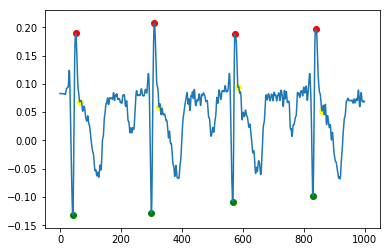

In [243]:
q_peaks, s_peaks, theta_peaks, p_peaks, r_peaks,drops,start_drops,end_drops, arr = step_by_step(folder='rabbit_20', subfolder_name='Rabbit_02_part_4', animal='rabbit')
# print(q_peaks[0])
print(type(r_peaks[0]))
print(type(q_peaks[0]))
peaks, av, var, ecg = find_r(ue, 'dog_17')
plt.plot(arr[0][1500:2500])
loc_s = np.array(np.where((r_peaks[0]<2500) & (r_peaks[0]>1500)))

a11 = (r_peaks[0][loc_s] - 0).reshape(-1)
ys = [arr[0][i] for i in a11]
plt.scatter(a11-1500, ys, color = 'red')

loc_s = np.array(np.where((q_peaks[0]<2500) & (q_peaks[0]>1500)))
a11 = (q_peaks[0][loc_s] - 0).reshape(-1)
ys = [arr[0][i] for i in a11]
plt.scatter(a11-1500, ys, color = 'green')

loc_s = np.array(np.where((s_peaks[0]<2500) & (s_peaks[0]>1500)))
a11 = (s_peaks[0][loc_s] - 0).reshape(-1)
ys = [arr[0][i] for i in a11]
plt.scatter(a11-1500, ys, color = 'yellow')


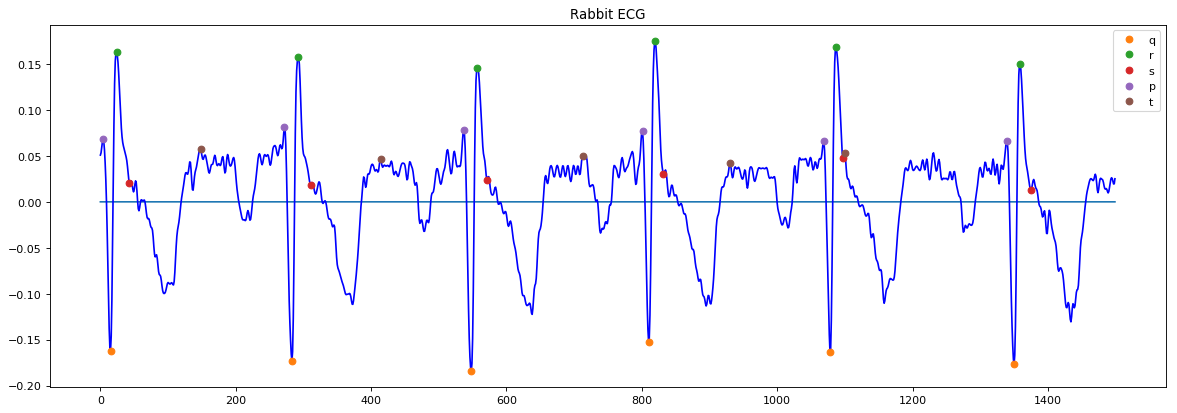

In [237]:
draw_graph(arr[0], q_ar=q_peaks[0], s_ar=s_peaks[0], r_ar=r_peaks[0], p_ar = p_peaks[0], t_ar =theta_peaks[0],  name ="Rabbit ECG", start=8500, shift=1500)

In [232]:
ue = upload_file (folder='mouse_8', subfolder_name='Mouse_04')
ue = butterworth_filtering (lcf=lcf, hcf=hcf, fs=fs, ecg=ue)

In [91]:
ue = upload_file (folder='rabbit_20', subfolder_name='Rabbit_02_part_1')
ue = butterworth_filtering (lcf=lcf, hcf=hcf, fs=fs, ecg=ue)